# Develop negative log-likelihood with scaled inputs

In [1]:
from __future__ import annotations

import numdifftools as nd
import numpy as np

from numpy.typing import ArrayLike
from scipy.fft import rfft, irfft, rfftfreq
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.figure import figaspect
from scipy.optimize import approx_fprime
from numpy.random import default_rng

import thztools as thz
from thztools.thztools import _costfun_noisefit as costfun

## Simulate measurements

In [2]:
rng = np.random.default_rng(0)
n = 256
m = 64
ts = 0.05
thz.global_options.sampling_time = ts
t = thz.timebase(n)
mu = thz.wave(n)
sigma = np.array([1e-5, 1e-2, 1e-3])
noise_model = thz.NoiseModel(
    sigma_alpha=sigma[0], sigma_beta=sigma[1], sigma_tau=sigma[2]
)
noise = noise_model.noise((np.ones((m, 1)) * mu), seed=0)
x = np.array(mu + noise)
delta_mu = np.zeros(n)
delta_a = np.zeros(m - 1)
eta = np.zeros(m - 1)

logv = np.log(sigma**2)
scale_sigma_alpha = noise_model.sigma_alpha
scale_sigma_beta = noise_model.sigma_beta
scale_sigma_tau = noise_model.sigma_tau
scale_delta_mu = 1e-0 * noise_model.amplitude(mu)
scale_delta_a = 1e-4 * np.ones(m - 1)
scale_eta = 1e-3 * np.ones(m - 1)

## Check gradient

In [3]:
_, grad_delta_mu_tdnll = costfun(
    x,
    logv[0],
    logv[1],
    logv[2],
    delta_mu,
    delta_a,
    eta / ts,
    fix_logv_alpha=True,
    fix_logv_beta=True,
    fix_logv_tau=True,
    fix_delta_mu=False,
    fix_delta_a=True,
    fix_eta=True,
    scale_sigma_alpha=1.0,
    scale_sigma_beta=1.0,
    scale_sigma_tau=1.0,
    scale_delta_mu=np.ones(n),
    scale_delta_a=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
)

_, grad_delta_mu_costfun = costfun(
    x,
    np.log(np.exp(logv[0]) / scale_sigma_alpha**2),
    np.log(np.exp(logv[1]) / scale_sigma_beta**2),
    np.log(np.exp(logv[2]) / scale_sigma_tau**2),
    delta_mu / scale_delta_mu,
    delta_a,
    eta / ts,
    fix_logv_alpha=True,
    fix_logv_beta=True,
    fix_logv_tau=True,
    fix_delta_mu=False,
    fix_delta_a=True,
    fix_eta=True,
    scale_sigma_alpha=scale_sigma_alpha,
    scale_sigma_beta=scale_sigma_beta,
    scale_sigma_tau=scale_sigma_tau,
    scale_delta_mu=scale_delta_mu,
    scale_delta_a=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
)

grad_delta_mu_nd = nd.Gradient(
    lambda _delta_mu: costfun(
        x,
        logv[0],
        logv[1],
        logv[2],
        _delta_mu,
        delta_a,
        eta / ts,
        fix_logv_alpha=True,
        fix_logv_beta=True,
        fix_logv_tau=True,
        fix_delta_mu=True,
        fix_delta_a=True,
        fix_eta=True,
        scale_sigma_alpha=1.0,
        scale_sigma_beta=1.0,
        scale_sigma_tau=1.0,
        scale_delta_mu=np.ones(n),
        scale_delta_a=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
    )[0],
    step=1e-6,
)(delta_mu)

np.stack(
    (
        grad_delta_mu_tdnll,
        grad_delta_mu_costfun / scale_delta_mu,
        grad_delta_mu_nd,
    )
).T

array([[-2.87929456e+02, -2.87929456e+02, -2.87929068e+02],
       [ 4.33389296e+01,  4.33389296e+01,  4.33387811e+01],
       [-5.71274067e+02, -5.71274067e+02, -5.71272995e+02],
       [-1.32894398e+01, -1.32894398e+01, -1.32893470e+01],
       [ 5.33919772e+02,  5.33919772e+02,  5.33918824e+02],
       [-1.46561787e+02, -1.46561787e+02, -1.46561361e+02],
       [-8.29220782e+02, -8.29220782e+02, -8.29218936e+02],
       [-5.99986291e+02, -5.99986291e+02, -5.99984957e+02],
       [ 5.13902903e+02,  5.13902903e+02,  5.13901844e+02],
       [ 1.02863895e+03,  1.02863895e+03,  1.02863694e+03],
       [ 3.84980402e+02,  3.84980402e+02,  3.84979535e+02],
       [ 3.85784674e+01,  3.85784674e+01,  3.85784580e+01],
       [ 1.94535230e+03,  1.94535230e+03,  1.94534856e+03],
       [ 2.35955711e+02,  2.35955711e+02,  2.35955302e+02],
       [ 1.19037919e+03,  1.19037919e+03,  1.19037703e+03],
       [ 5.91266358e+02,  5.91266358e+02,  5.91265194e+02],
       [ 3.60298230e+02,  3.60298230e+02

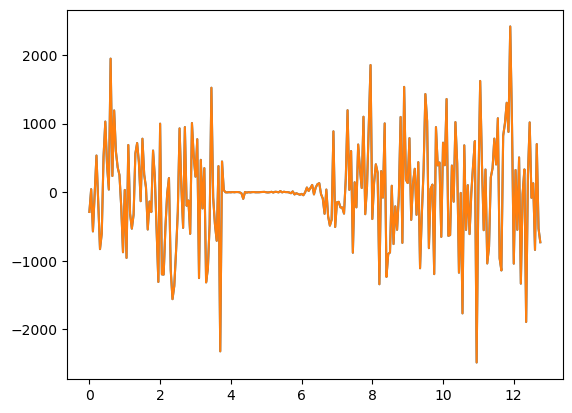

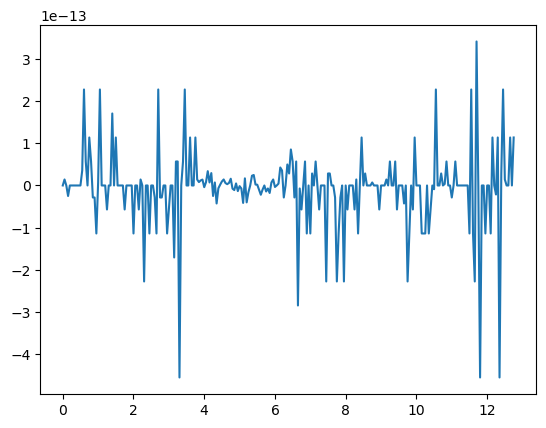

In [4]:
plt.plot(t, grad_delta_mu_tdnll)
plt.plot(t, grad_delta_mu_costfun / scale_delta_mu)
plt.show()
plt.plot(t, grad_delta_mu_tdnll - grad_delta_mu_costfun / scale_delta_mu)
plt.show()

In [5]:
val, grad_logv_tdnll = costfun(
    x,
    logv[0],
    logv[1],
    logv[2],
    delta_mu,
    delta_a,
    eta / ts,
    fix_logv_alpha=False,
    fix_logv_beta=False,
    fix_logv_tau=False,
    fix_delta_mu=True,
    fix_delta_a=True,
    fix_eta=True,
    scale_sigma_alpha=1.0,
    scale_sigma_beta=1.0,
    scale_sigma_tau=1.0,
    scale_delta_mu=scale_delta_mu,
    scale_delta_a=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
)

val_scaled_v, grad_logv_costfun_v = costfun(
    x,
    logv[0],
    logv[1],
    logv[2],
    delta_mu,
    delta_a,
    eta / ts,
    fix_logv_alpha=False,
    fix_logv_beta=False,
    fix_logv_tau=False,
    fix_delta_mu=True,
    fix_delta_a=True,
    fix_eta=True,
    scale_sigma_alpha=1.0,
    scale_sigma_beta=1.0,
    scale_sigma_tau=1.0,
    scale_delta_mu=scale_delta_mu,
    scale_delta_a=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
)

val_scaled, grad_logv_costfun = costfun(
    x,
    np.log(np.exp(logv[0]) / scale_sigma_alpha**2),
    np.log(np.exp(logv[1]) / scale_sigma_beta**2),
    np.log(np.exp(logv[2]) / scale_sigma_tau**2),
    delta_mu,
    delta_a,
    eta / ts,
    fix_logv_alpha=False,
    fix_logv_beta=False,
    fix_logv_tau=False,
    fix_delta_mu=True,
    fix_delta_a=True,
    fix_eta=True,
    scale_sigma_alpha=scale_sigma_alpha,
    scale_sigma_beta=scale_sigma_beta,
    scale_sigma_tau=scale_sigma_tau,
    scale_delta_mu=scale_delta_mu,
    scale_delta_a=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
)

grad_logv_nd = nd.Gradient(
    lambda _logv: costfun(
        x,
        np.log(np.exp(_logv[0]) / scale_sigma_alpha**2),
        np.log(np.exp(_logv[1]) / scale_sigma_beta**2),
        np.log(np.exp(_logv[2]) / scale_sigma_tau**2),
        delta_mu,
        delta_a,
        eta / ts,
        fix_logv_alpha=True,
        fix_logv_beta=True,
        fix_logv_tau=True,
        fix_delta_mu=True,
        fix_delta_a=True,
        fix_eta=True,
        scale_sigma_alpha=scale_sigma_alpha,
        scale_sigma_beta=scale_sigma_beta,
        scale_sigma_tau=scale_sigma_tau,
        scale_delta_mu=scale_delta_mu,
        scale_delta_a=scale_delta_a,
        scale_eta=np.ones(m - 1),
    )[0]
)(logv)

print(f"{val =}")
print(f"{val_scaled_v =}")
print(f"{val_scaled =}")
np.stack(
    (
        grad_logv_tdnll,
        grad_logv_costfun_v,
        grad_logv_costfun,
        grad_logv_nd,
    )
).T

val =-18.171733595409428
val_scaled_v =-18.171733595409428
val_scaled =-18.171733595409428


array([[-0.80023876, -0.80023876, -0.80023876, -0.80023876],
       [-0.89284396, -0.89284396, -0.89284396, -0.89284396],
       [-0.06160828, -0.06160828, -0.06160828, -0.06160828]])

In [6]:
_, grad_delta_a_tdnll = costfun(
    x,
    logv[0],
    logv[1],
    logv[2],
    delta_mu,
    delta_a,
    eta / ts,
    fix_logv_alpha=True,
    fix_logv_beta=True,
    fix_logv_tau=True,
    fix_delta_mu=True,
    fix_delta_a=False,
    fix_eta=True,
    scale_sigma_alpha=1.0,
    scale_sigma_beta=1.0,
    scale_sigma_tau=1.0,
    scale_delta_mu=scale_delta_mu,
    scale_delta_a=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
)

grad_delta_a_nd = nd.Gradient(
    lambda _delta_a: costfun(
        x,
        logv[0],
        logv[1],
        logv[2],
        delta_mu,
        _delta_a,
        eta / ts,
        fix_logv_alpha=True,
        fix_logv_beta=True,
        fix_logv_tau=True,
        fix_delta_mu=True,
        fix_delta_a=True,
        fix_eta=True,
        scale_sigma_alpha=1.0,
        scale_sigma_beta=1.0,
        scale_sigma_tau=1.0,
        scale_delta_mu=scale_delta_mu,
        scale_delta_a=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
    )[0]
)(delta_a)

np.stack((grad_delta_a_tdnll, grad_delta_a_nd)).T

array([[-0.05020644, -0.05020644],
       [ 0.07164942,  0.07164942],
       [-0.17680859, -0.17680859],
       [-0.26682736, -0.26682736],
       [ 0.16177697,  0.16177697],
       [-0.37383523, -0.37383523],
       [-0.18750826, -0.18750826],
       [ 0.09838393,  0.09838393],
       [-0.11474184, -0.11474184],
       [-0.14288809, -0.14288809],
       [-0.00860305, -0.00860305],
       [-0.12485866, -0.12485866],
       [-0.10072966, -0.10072966],
       [-0.13179101, -0.13179101],
       [-0.0732175 , -0.0732175 ],
       [-0.30684625, -0.30684625],
       [-0.1225423 , -0.1225423 ],
       [-0.23854239, -0.23854239],
       [ 0.0633632 ,  0.0633632 ],
       [-0.42836695, -0.42836695],
       [-0.01968772, -0.01968772],
       [ 0.09013447,  0.09013447],
       [-0.12278927, -0.12278927],
       [-0.05732659, -0.05732659],
       [-0.24922719, -0.24922719],
       [-0.01801294, -0.01801294],
       [ 0.0984834 ,  0.0984834 ],
       [-0.34299289, -0.34299289],
       [-0.02891249,

In [7]:
_, grad_eta_tdnll = costfun(
    x,
    logv[0],
    logv[1],
    logv[2],
    delta_mu,
    delta_a,
    eta / ts,
    fix_logv_alpha=True,
    fix_logv_beta=True,
    fix_logv_tau=True,
    fix_delta_mu=True,
    fix_delta_a=True,
    fix_eta=False,
    scale_sigma_alpha=1.0,
    scale_sigma_beta=1.0,
    scale_sigma_tau=1.0,
    scale_delta_mu=scale_delta_mu,
    scale_delta_a=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
)

grad_eta_nd = nd.Gradient(
    lambda _eta_scaled: costfun(
        x,
        logv[0],
        logv[1],
        logv[2],
        delta_mu,
        delta_a,
        _eta_scaled,
        fix_logv_alpha=True,
        fix_logv_beta=True,
        fix_logv_tau=True,
        fix_delta_mu=True,
        fix_delta_a=True,
        fix_eta=True,
        scale_sigma_alpha=1.0,
        scale_sigma_beta=1.0,
        scale_sigma_tau=1.0,
        scale_delta_mu=scale_delta_mu,
        scale_delta_a=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
    )[0]
)(eta)

np.stack((grad_eta_tdnll, grad_eta_nd)).T

array([[-0.2333002 , -0.2333002 ],
       [-0.01137365, -0.01137365],
       [-0.42064032, -0.42064032],
       [-0.28497965, -0.28497965],
       [-0.57276895, -0.57276895],
       [ 0.37554937,  0.37554937],
       [ 0.17260522,  0.17260522],
       [-0.16163771, -0.16163771],
       [ 0.00722368,  0.00722368],
       [ 0.18637408,  0.18637408],
       [-0.46726214, -0.46726214],
       [ 0.06459656,  0.06459656],
       [ 0.4849538 ,  0.4849538 ],
       [-0.32309831, -0.32309831],
       [ 0.09324351,  0.09324351],
       [ 0.18897729,  0.18897729],
       [-0.5627344 , -0.5627344 ],
       [-0.07152733, -0.07152733],
       [-0.37194246, -0.37194246],
       [ 0.03145816,  0.03145816],
       [ 0.06104106,  0.06104106],
       [-0.71867194, -0.71867194],
       [-0.31721446, -0.31721446],
       [-0.17355506, -0.17355506],
       [-0.10634227, -0.10634227],
       [-0.36894173, -0.36894173],
       [-0.29614932, -0.29614932],
       [-0.34754866, -0.34754866],
       [ 0.04282608,

## Estimate noise parameters with revised NLL

In [8]:
result = thz.noisefit(
    x.T,
    sigma_alpha0=sigma[0],
    sigma_beta0=sigma[1],
    sigma_tau0=sigma[2],
    dt=ts,
    fix_a=False,
    fix_eta=False,
)

In [9]:
print(result.diagnostic["message"])

Optimization terminated successfully.


In [10]:
sigma_out = np.array(
    [
        result.noise_model.sigma_alpha,
        result.noise_model.sigma_beta,
        result.noise_model.sigma_tau,
    ]
) * np.sqrt(m / (m - 1))
sigma_err = np.sqrt(
    np.array(
        [result.err_sigma_alpha, result.err_sigma_beta, result.err_sigma_tau]
    )
    * m
    / (m - 1)
)
for sigma_in, sigma_out, err in zip(sigma, sigma_out, sigma_err):
    print(f"Input: {sigma_in:6.4g}\t Output: {sigma_out:6.4g} ± {err:6.4g}")

Input:  1e-05	 Output: 9.995e-06 ± 0.002761
Input:   0.01	 Output: 0.009874 ± 0.1008
Input:  0.001	 Output: 0.000903 ± 0.08326


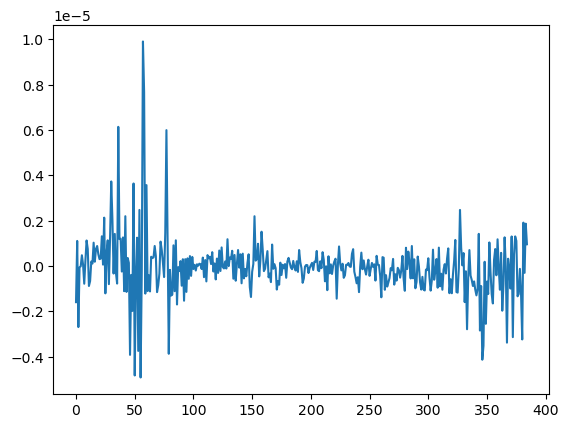

In [11]:
plt.plot(result.diagnostic["jac"])
plt.show()

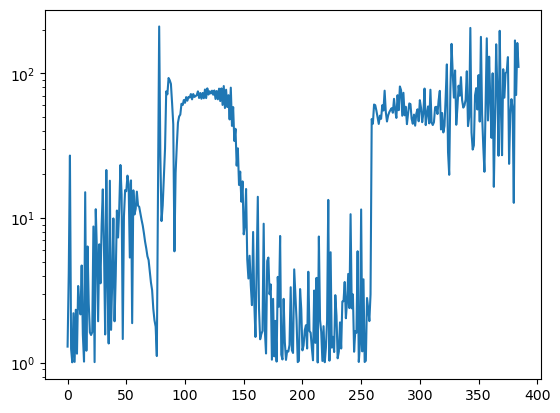

In [12]:
plt.semilogy(np.diag(result.diagnostic["hess_inv"]))
plt.show()

In [13]:
np.diag(result.diagnostic["hess_inv"][:3, :3])

array([ 1.28945002,  4.16529588, 27.01896796])

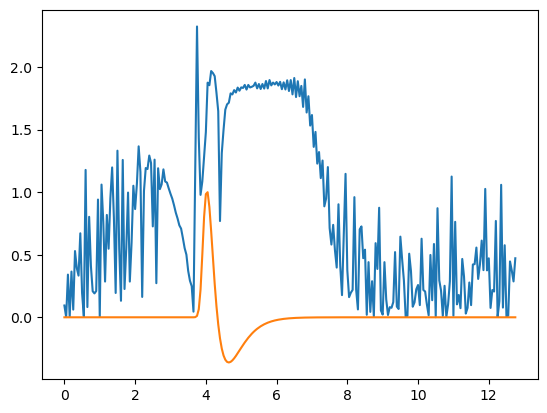

In [14]:
plt.plot(t, np.log10(np.diag(result.diagnostic["hess_inv"])[3 : 3 + n]))
plt.plot(t, mu)
plt.show()

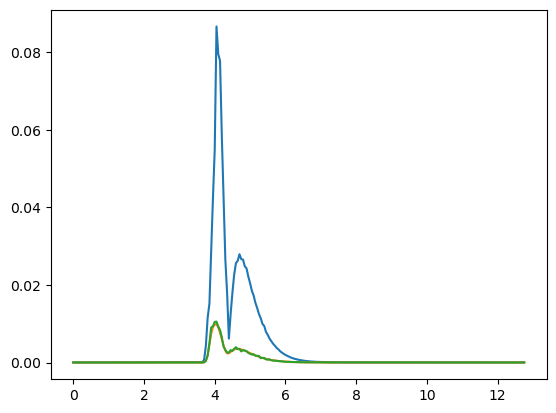

In [15]:
noise_model_fit = thz.NoiseModel(
    sigma_alpha=result.noise_model.sigma_alpha,
    sigma_beta=result.noise_model.sigma_beta,
    sigma_tau=result.noise_model.sigma_tau,
)

plt.plot(t, result.err_mu)
plt.plot(t, noise_model_fit.amplitude(result.mu))
plt.plot(t, np.std(x, axis=0))
plt.show()

## Repeat fit with amplitudes and delays fixed

In [16]:
result = thz.noisefit(
    x.T,
    sigma_alpha0=sigma[0],
    sigma_beta0=sigma[1],
    sigma_tau0=sigma[2],
    dt=ts,
    fix_a=True,
    fix_eta=True,
)
print(result.diagnostic["message"])

Optimization terminated successfully.


In [17]:
sigma_out = np.array(
    [
        result.noise_model.sigma_alpha,
        result.noise_model.sigma_beta,
        result.noise_model.sigma_tau,
    ]
) * np.sqrt(m / (m - 1))
sigma_err = np.sqrt(
    np.array(
        [result.err_sigma_alpha, result.err_sigma_beta, result.err_sigma_tau]
    )
    * m
    / (m - 1)
)
for sigma_in, sigma_out, err in zip(sigma, sigma_out, sigma_err):
    print(f"Input: {sigma_in:6.4g}\t Output: {sigma_out:6.4g} ± {err:6.4g}")

Input:  1e-05	 Output: 9.999e-06 ± 0.002739
Input:   0.01	 Output: 0.009909 ± 0.1012
Input:  0.001	 Output: 0.0009765 ± 0.07481


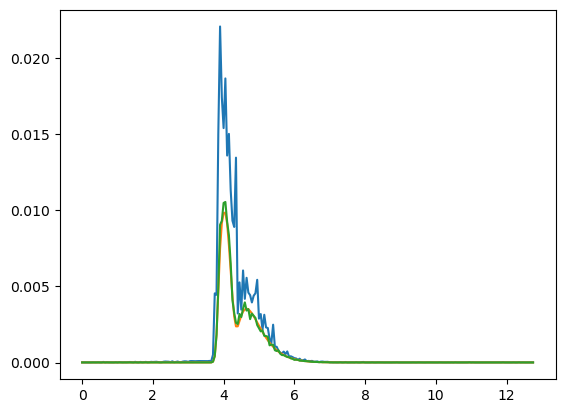

In [18]:
plt.plot(t, result.err_mu)
plt.plot(t, noise_model_fit.amplitude(result.mu))
plt.plot(t, np.std(x, axis=0))
plt.show()

In [19]:
v_t = np.var(x, axis=0)
mu_t = np.mean(x, axis=0)

f_scaled = rfftfreq(n)
w_scaled = 2 * np.pi * f_scaled
dmu_dt = np.fft.irfft(1j * w_scaled * np.fft.rfft(mu_t), n=n)

In [26]:
a_matrix = np.stack([np.ones_like(mu_t), mu_t**2, dmu_dt**2], axis=1)

In [27]:
v_parms = np.linalg.lstsq(a_matrix, v_t, rcond=None)

In [28]:
v_parms

(array([-7.47130591e-08,  1.04288469e-04,  4.34006079e-04]),
 array([4.80166708e-10]),
 3,
 array([16.00438849,  1.8160837 ,  0.13598621]))

In [29]:
x.shape

(64, 256)